# LFRic external forcing simulations

In [1]:
import warnings

warnings.filterwarnings("ignore")  # noqa

In [2]:
from functools import partial

In [3]:
from tqdm.notebook import tqdm

Scientific stack

In [4]:
import esmf_regrid
import iris
import iris.coord_systems
import iris.fileformats
import iris.plot as iplt
import iris.quickplot as qplt
import matplotlib.colors as mcol
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import numpy as np
from esmf_regrid.experimental.unstructured_scheme import (
    MeshToGridESMFRegridder,
    regrid_unstructured_to_rectilinear,
)
from iris.experimental.ugrid import PARSE_UGRID_ON_LOAD

# from iris.experimental import stratify
from matplotlib.offsetbox import AnchoredText

aeolus

In [6]:
import aeolus
from aeolus.calc import spatial_mean, time_mean, zonal_mean
from aeolus.const import init_const
from aeolus.coord import get_cube_rel_days, get_xy_coords, roll_cube_pm180
from aeolus.io import create_dummy_cube, load_vert_lev
from aeolus.model import um
from aeolus.plot import subplot_label_generator
from aeolus.subset import extract_last_n_days

In [7]:
%load_ext watermark

%watermark
%watermark -iv

Last updated: 2022-11-04T21:04:42.031387+00:00

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

Compiler    : GCC 10.4.0
OS          : Linux
Release     : 4.15.0-194-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 192
Architecture: 64bit

iris       : 3.3.0
aeolus     : 0.4.15+14.g02f78ce
numpy      : 1.23.4
esmf_regrid: 0.5.0
matplotlib : 3.6.1



In [8]:
from pouch.plot import (
    KW_AUX_TTL,
    KW_MAIN_TTL,
    KW_SBPLT_LABEL,
    KW_ZERO_LINE,
    figsave,
    linspace_pm1,
    use_style,
)

local scripts

In [10]:
import paths
from lfric_util import add_equally_spaced_height_coord, clean_attrs, ugrid_spatial_mean

### Some global definitions

Apply a custom `matplotlib` style.

In [11]:
plt.style.use("custom.mplstyle")

Select the run configuration

In [65]:
SIM_INFO = {"earth_like": {"title": "Earth-like", "planet": "earth", "timestep": 1800}}
sim_label = "earth_like"
const = init_const(SIM_INFO[sim_label]["planet"])

In [14]:
kappa = const.dry_air_gas_constant / const.dry_air_spec_heat_press

Common directory where to save plots.

In [15]:
plot_dir = mypaths.plot

### Load the data into a cube list

Use a callback function to attach a level height coordinate for convenience.

Note: adapt the file path to the one on your machine in the `mypaths.py` script.

In [29]:
runs = {}
for sim_label in tqdm(SIM_INFO.keys()):
    fnames = sorted(
        (mypaths.results_lfric / "external_forcing" / sim_label / "base").glob(
            f"*/*/lfric_diag.nc"
        ),
        key=lambda x: int(x.parent.parent.name),
    )
    with PARSE_UGRID_ON_LOAD.context():
        cl_raw = iris.load(
            fnames,
            callback=partial(add_equally_spaced_height_coord, model_top_height=32_000),
        )

        for cube in cl_raw:
            try:
                cube.attributes.pop("timeStamp")
                cube.attributes.pop("uuid")
            except KeyError:
                pass
        runs[sim_label] = cl_raw.concatenate(check_aux_coords=False)

  0%|          | 0/1 [00:00<?, ?it/s]

28-03-2022 11:31:37 iris.experimental.ugrid.load WARNING - *Assuming* 'topology_dimension'=1, from the attached connectivities of the mesh variable Mesh2d_edge.  However, Mesh2d_edge:topology_dimension = 2 -- ignoring this as it is inconsistent. [None._build_mesh]
28-03-2022 11:31:38 iris.experimental.ugrid.load WARNING - *Assuming* 'topology_dimension'=1, from the attached connectivities of the mesh variable Mesh2d_edge.  However, Mesh2d_edge:topology_dimension = 2 -- ignoring this as it is inconsistent. [None._build_mesh]
28-03-2022 11:31:39 iris.experimental.ugrid.load WARNING - *Assuming* 'topology_dimension'=1, from the attached connectivities of the mesh variable Mesh2d_edge.  However, Mesh2d_edge:topology_dimension = 2 -- ignoring this as it is inconsistent. [None._build_mesh]
28-03-2022 11:31:40 iris.experimental.ugrid.load WARNING - *Assuming* 'topology_dimension'=1, from the attached connectivities of the mesh variable Mesh2d_edge.  However, Mesh2d_edge:topology_dimension = 2

In [30]:
sim_label = "earth_like"
the_run = runs[sim_label]

In [36]:
for cube in the_run.extract(
    [
        "surface_tile_temperature",
        "air_potential_temperature",
        "eastward_wind",
        "northward_wind",
        "vertical wind on physics points",
    ]
):
    print(f"{cube.long_name:<50} | {cube.var_name:<20}")

air_potential_temperature                          | theta               
air potential temperature on W3 points             | theta_in_w3         
air potential temperature: physics predictor       | theta_star          
physics U wind on W3 points                        | u1_in_w3            
eastward_wind: physics predictor                   | u_star1             
physics U wind on W3 points: physics predictor     | u1_in_w3_star       
eastward_wind                                      | u1                  
northward_wind: physics predictor                  | u_star2             
northward_wind                                     | u2                  
physics V wind on W3 points                        | u2_in_w3            
physics V wind on W3 points: physics predictor     | u2_in_w3_star       
vertical wind on physics points                    | w_physics           


In [37]:
theta = the_run.extract_cube("theta")

In [42]:
theta_at_sfc = theta.extract(iris.Constraint(**{um.z: 0}))

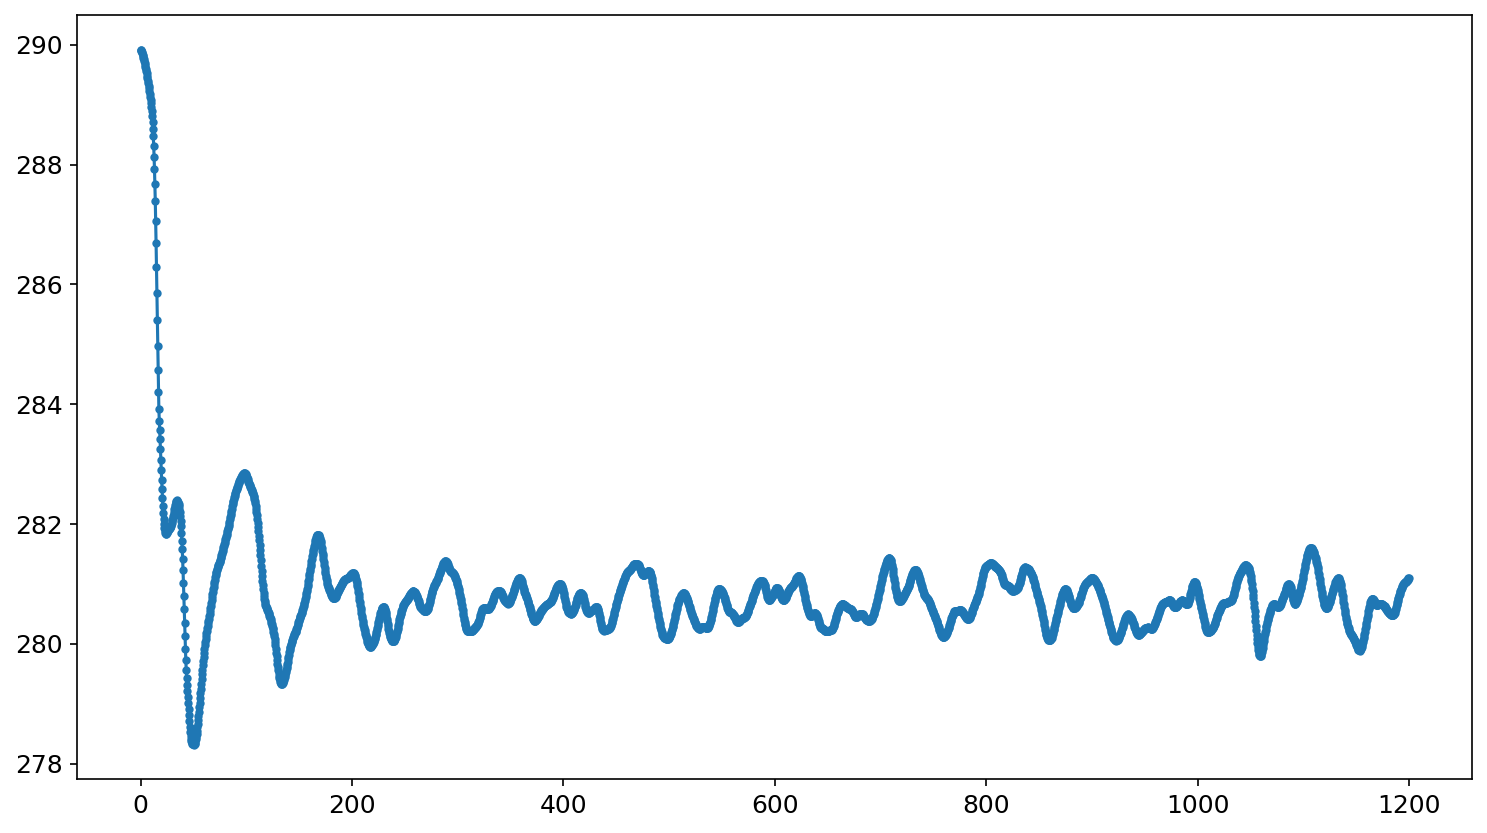

In [45]:
plt.plot(
    get_cube_rel_days(theta_at_sfc), ugrid_spatial_mean(theta_at_sfc).data, marker="."
)

In [46]:
tgt_cube = create_dummy_cube(
    nlat=90, nlon=144, pm180=True
)  # Use a non-standard number of points to match UoE SA suites

In [48]:
RESULTS = {}
for sim_label in tqdm(SIM_INFO.keys()):
    RESULTS[sim_label] = {}
    u_w3 = runs[sim_label].extract_cube(
        iris.Constraint(cube_func=lambda cube: cube.var_name == "u1_in_w3")
    )
    u_w3_tm = time_mean(u_w3)
    v_w3 = runs[sim_label].extract_cube(
        iris.Constraint(cube_func=lambda cube: cube.var_name == "u2_in_w3")
    )
    v_w3_tm = time_mean(v_w3)

    exner = runs[sim_label].extract_cube(
        iris.Constraint(cube_func=lambda cube: cube.var_name == "exner")
    )

    pres = exner.copy(
        data=const.reference_surface_pressure.data * (exner.data ** (1 / kappa.data))
    )
    pres.rename("air_pressure")
    pres.units = "Pa"
    pres_tm = time_mean(pres)
    
    theta = time_mean(runs[sim_label].extract_cube("theta"))
    
    regridder = MeshToGridESMFRegridder(u_w3_tm, tgt_cube)
    
    RESULTS[sim_label]["u_w3"] = u_w3_tm
    RESULTS[sim_label]["v_w3"] = v_w3_tm
    RESULTS[sim_label]["theta"] = theta

    RESULTS[sim_label]["u_reg"] = regridder(u_w3_tm)
    RESULTS[sim_label]["v_reg"] = regridder(v_w3_tm)
    RESULTS[sim_label]["pres_reg"] = regridder(pres_tm)
    RESULTS[sim_label]["theta_reg"] = regridder(theta)

  0%|          | 0/1 [00:00<?, ?it/s]

In [55]:
xy_slice = slice(None, None, 2)
x_slice = slice(None, None, 2)
y_slice = slice(None, None, 2)

ilev = 20

KW_T_SFC = dict(cmap="plasma", vmin=250, vmax=310)
KW_WINDS = dict(facecolors="#222222", edgecolors="#DDDDDD", linewidths=1)

Saved to ../plots/lfric_atm_thai_earth_like_C24_dt-1800p0__theta__lev0.png


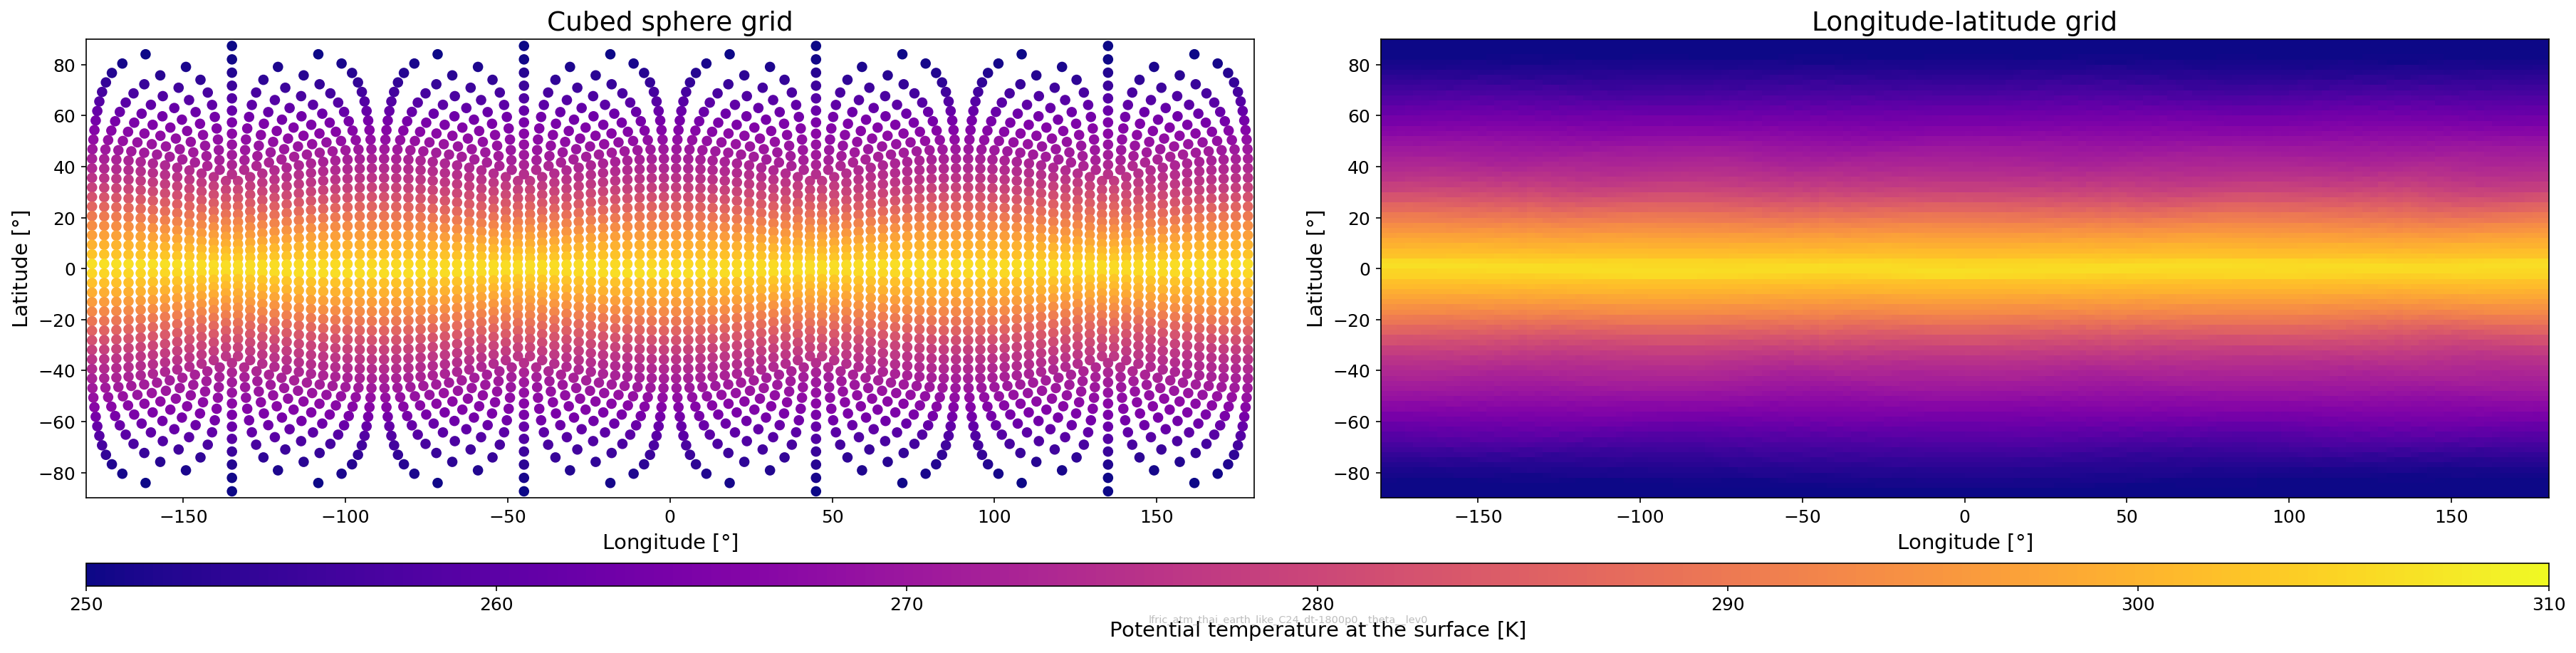

In [72]:
fig = plt.figure(figsize=(24, 6), constrained_layout=True)
axd = fig.subplot_mosaic(
    [["orig", "reg"], ["cax"] * 2], gridspec_kw=dict(height_ratios=[1, 0.05])
)
for ax in axd.values():
    ax.set_xlabel("Longitude [$\degree$]")
    ax.set_ylabel("Latitude [$\degree$]")
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)

# fig.suptitle(f"Potential temperature and winds at {vert_lev[ilev]:.0f} m")
fig.suptitle(f"1200 day average of the {SIM_INFO[sim_label]['title']} case")


ax = axd["orig"]
ax.set_title("Cubed sphere grid")
p0 = ax.scatter(
    RESULTS[sim_label]["theta"].coord(um.x).points,
    RESULTS[sim_label]["theta"].coord(um.y).points,
    c=RESULTS[sim_label]["theta"].extract(iris.Constraint(**{um.z: 0})).data,
    **KW_T_SFC,
)

# ax.quiver(
#     RESULTS[sim_label]["u_w3"].coord(um.x).points[xy_slice],
#     RESULTS[sim_label]["u_w3"].coord(um.y).points[xy_slice],
#     RESULTS[sim_label]["u_w3"].data[ilev, xy_slice],
#     RESULTS[sim_label]["v_w3"].data[ilev, xy_slice],
#     **KW_WINDS,
# )

ax = axd["reg"]
ax.set_title("Longitude-latitude grid")
p0 = ax.pcolormesh(
    RESULTS[sim_label]["theta_reg"].coord(um.x).points,
    RESULTS[sim_label]["theta_reg"].coord(um.y).points,
    RESULTS[sim_label]["theta_reg"].extract(iris.Constraint(**{um.z: 0})).data,
    **KW_T_SFC,
)

# ax.quiver(
#     RESULTS[sim_label]["u_reg"].coord(um.x).points[x_slice],
#     RESULTS[sim_label]["u_reg"].coord(um.y).points[y_slice],
#     RESULTS[sim_label]["u_reg"].data[ilev, y_slice, x_slice],
#     RESULTS[sim_label]["v_reg"].data[ilev, y_slice~, x_slice],
#     **KW_WINDS,
# )

cbar = fig.colorbar(p0, cax=axd["cax"], orientation="horizontal")
cbar.ax.set_xlabel("Potential temperature at the surface [$K$]");
figsave(fig, plot_dir / f"lfric_atm_thai_{sim_label}_C24_dt-{SIM_INFO[sim_label]['timestep']}p0__theta__lev0")

In [59]:
from aeolus.calc import meridional_mean

Saved to ../plots/lfric_atm_thai_earth_like_C24_dt-1800p0__theta__lev0__mm.png


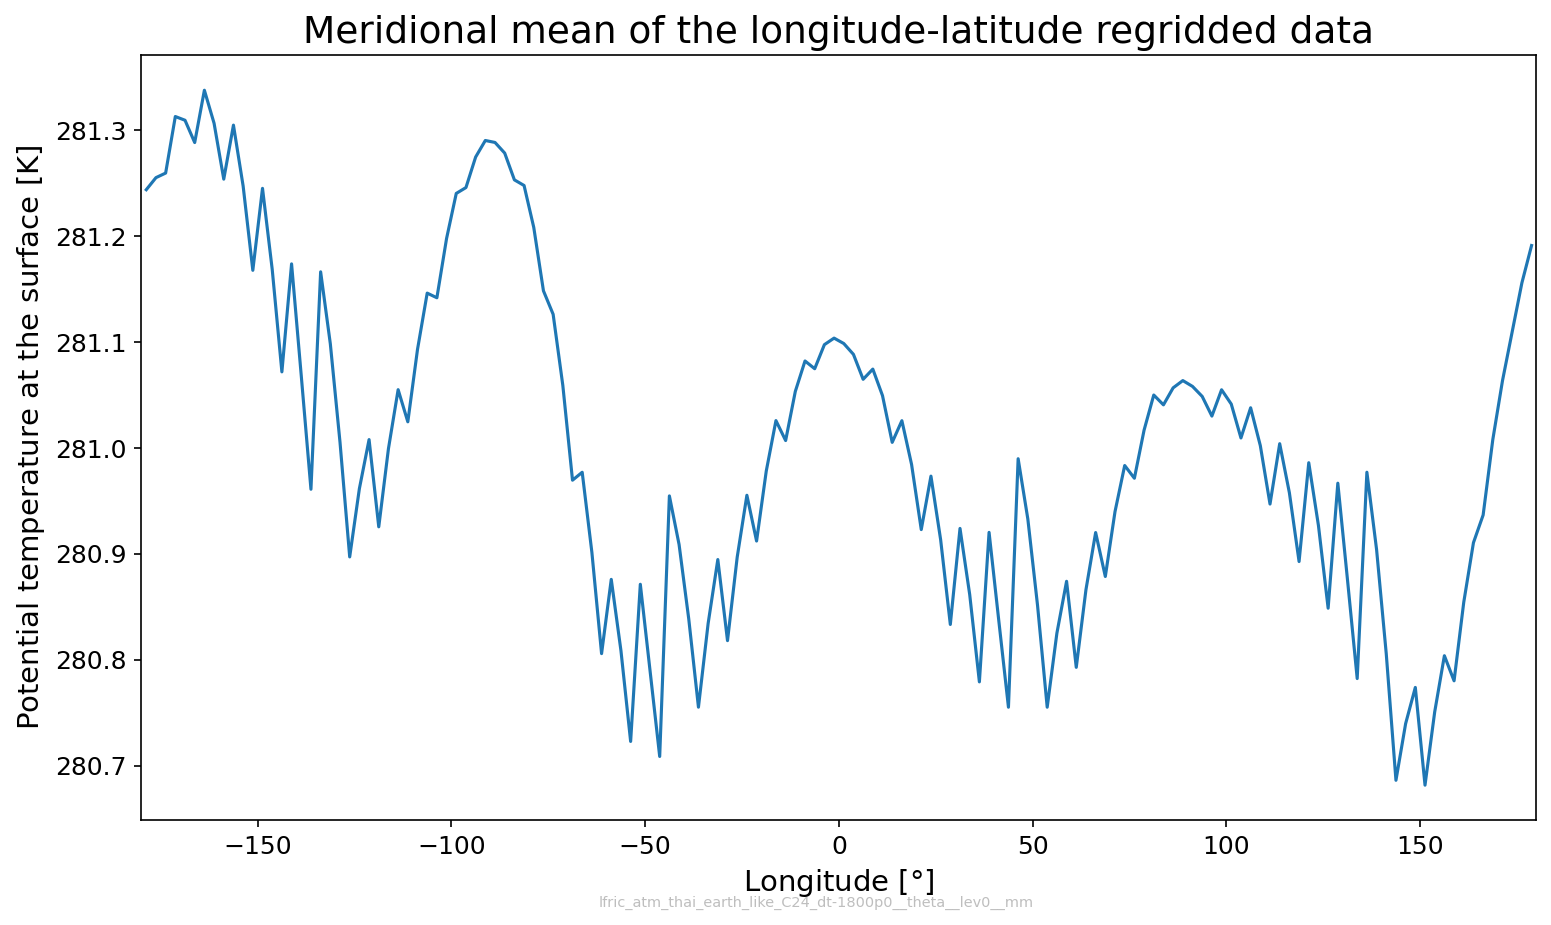

In [73]:
fig, ax = plt.subplots()
ax.plot(
    RESULTS[sim_label]["theta_reg"].coord(um.x).points,
    meridional_mean(RESULTS[sim_label]["theta_reg"]).data[0, ...]
)
ax.set_ylabel("Potential temperature at the surface [$K$]")
ax.set_xlabel("Longitude [$\degree$]")
ax.set_xlim(-180, 180)
ax.set_title("Meridional mean of the longitude-latitude regridded data")
figsave(fig, plot_dir / f"lfric_atm_thai_{sim_label}_C24_dt-{SIM_INFO[sim_label]['timestep']}p0__theta__lev0__mm")